In [2]:
from facetorch import FaceAnalyzer
from omegaconf import OmegaConf
from typing import Dict
import operator
import torchvision
import torch
import numpy as np
import os
import operator
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle5 as pickle
from tqdm import tqdm
import os
import json
import csv
import shutil

/home/qihan/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Initialize the analyzer

In [3]:

# initialize
path_config="gpu.config.yml"
cfg = OmegaConf.load(path_config)
analyzer = FaceAnalyzer(cfg.analyzer)

#Warm up
path_img_input="./test_error_1/frame_0.png"
response=None
# warmup
response = analyzer.run(
        path_image=path_img_input,
        batch_size=cfg.batch_size,
        fix_img_size=cfg.fix_img_size,
        return_img_data=False,
        include_tensors=True,
    )

Define functions

In [4]:
def generate_string(input_dir):
    # Split the input directory into parts
    parts = input_dir.split('/')
    
    # Get the last part of the directory
    last_part = parts[-1]
    
    # Split the last part by underscore
    last_part_parts = last_part.split('_')
    
    # Get the video name and frame rate
    video_name = "_".join(last_part_parts[:3])
    frame_rate = last_part_parts[6]
    
    # Generate the string
    result = f"Similarity Matrix, {video_name}, fps={frame_rate}"
    
    return result



In [3]:
def get_response_dict(input_dir):
    # Get a list of all image files in the "./test" directory
    image_files = [file for file in os.listdir(input_dir) if file.endswith(".png")]

    # Create an empty dictionary to store the responses
    responses_dict = {}
    responses_dict_path = os.path.join(input_dir, 'responses_dict.pkl')
    if os.path.exists(responses_dict_path):
        # Load the responses_dict from the pickle file
        saved_responses_dict = read_responses_dict(input_dir)
    
    # Remove the image files that are already in the responses_dict keys
    image_files = [file for file in image_files if ((file not in saved_responses_dict.keys()) and (file.endswith(".png")))]
    # Iterate over each image file with a progress bar
    for image_file in tqdm(image_files):
        
        # Get the full path of the image file
        image_path = os.path.join(input_dir, image_file)
        
        # Run the analyzer on the image
        response = analyzer.run(
            path_image=image_path,
            batch_size=cfg.batch_size,
            fix_img_size=cfg.fix_img_size,
            return_img_data=cfg.return_img_data,
            include_tensors=cfg.include_tensors,
        )
        if len(response.faces) == 0:
            print(f"No face detected in {image_file}")
            continue
        # Add the response to the dictionary with the image file name as the key
        responses_dict[image_file] = response.faces[0].preds["embed"].logits
    
    responses_dict = dict(sorted(responses_dict.items(), key=lambda x: int(''.join(filter(str.isdigit, x[0])))))
    return responses_dict

def read_responses_dict(input_dir):
    # Check if the responses_dict file exists
    responses_dict_path = os.path.join(input_dir, 'responses_dict.pkl')
    if not os.path.exists(responses_dict_path):
        print("responses_dict.pkl file does not exist in the input directory.")
        return None
        
    # Load the responses_dict from the pickle file
    with open(responses_dict_path, 'rb') as file:
        responses_dict = pickle.load(file)
    return responses_dict

def cosine_similarity(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)


In [6]:



def get_similarity_matrix(input_dir, compare_dir=None):
    if os.path.exists(os.path.join(input_dir, 'similarity_matrix_compare_neutral.png')):
        return
    
    responses_dict_1 = read_responses_dict(input_dir)
    if compare_dir is not None:
        responses_dict_2 = read_responses_dict(compare_dir)
    else:
        responses_dict_2 = responses_dict_1
    similarity_matrix = {}

    # Iterate over each pair of keys in responses_dict
    for key_1, value_1 in responses_dict_1.items():
        for key_2, value_2 in responses_dict_2.items():
            # Calculate the cosine similarity between value_1 and value_2
            similarity = cosine_similarity(value_1, value_2, dim=0).item()
            
            # Add the similarity to the similarity matrix with the key pair as the key
            similarity_matrix[key_1 + "+" + key_2] = similarity

    # Convert the similarity matrix to a dataframe
    similarity_df = pd.DataFrame.from_dict(similarity_matrix, orient='index')
    # Reset the index and split the key pair into separate columns
    similarity_df.reset_index(inplace=True)
    similarity_df[['key_1', 'key_2']] = similarity_df['index'].str.split('+', expand=True)
    # Convert the key_1 and key_2 columns to numeric type
    similarity_df['key_1'] = similarity_df['key_1'].str.extract('(\d+)', expand=False).astype(int)

    similarity_df['key_2'] = similarity_df['key_2'].str.extract('(\d+)', expand=False).astype(int)

    # Sort the dataframe by key_1 and key_2 columns
    similarity_df = similarity_df.sort_values(['key_1', 'key_2'])

    # Pivot the dataframe to create a matrix-like structure
    similarity_matrix_df = similarity_df.pivot(index='key_1', columns='key_2', values=0)

    # Create a heatmap of the similarity matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix_df, cmap='coolwarm', fmt=".2f")
    if compare_dir is not None:
        plt.title(generate_string(input_dir))
    else:
        plt.title(generate_string(input_dir)+"compared to neutral baseline")
    plt.xlabel('frames')
    plt.ylabel('frames')
    if compare_dir is not None:
        plt.savefig(os.path.join(input_dir, 'similarity_matrix_compare_neutral.png'))
    else:
        plt.savefig(os.path.join(input_dir, 'similarity_matrix.png'))
    return
    


In [7]:

def remove_talking_frames(input_dir, last_time_above_threshold):
    # Load the similarity matrix
    with open(os.path.join(input_dir, 'responses_dict.pkl'), 'rb') as file:
        responses_dict = pickle.load(file)
    
    # Get the frame rate of the video
    frame_rate = 30
    key_to_delete=[]
    for key in responses_dict.keys():
    # Get the time of each frame
        times = int(key.split('_')[1].split('.')[0]) / frame_rate
        if times < last_time_above_threshold:
            key_to_delete.append(key)
    for key in key_to_delete:
        del responses_dict[key]
    # Save the new dictionary as a pickle file
    with open(os.path.join(input_dir, 'responses_dict.pkl'), 'wb') as file:
        pickle.dump(responses_dict, file)
    
    return




Test with one episode

In [ ]:
import os
import re
import wave
path_to_video_dir = "/media/qihan/CORSAIR/Test/Data_clean/User_3/video_2/3_0_3_video_2_framerate_3_faces"
path_to_audio_file = re.sub(r'_video_2_framerate_\d+_faces', '_audio.wav', path_to_video_dir).replace('video_2', 'audio')
# Specify the path to the audio file

# Open the audio file
def get_auio_length(path_to_audio_file):
    with wave.open(path_to_audio_file, 'rb') as audio_file:
        # Get the number of frames in the audio file
        num_frames = audio_file.getnframes()
        
        # Get the frame rate of the audio file
        frame_rate = audio_file.getframerate()
        
        # Calculate the length of the audio file in seconds
        audio_length = num_frames / frame_rate
    return audio_length

last_speech_time = get_auio_length(path_to_audio_file)
print(last_speech_time)
remove_talking_frames(path_to_video_dir, last_speech_time)
get_similarity_matrix(path_to_video_dir)







Batch process all episodes

In [ ]:

super_dir = "/media/qihan/CORSAIR/Test/Data_clean/User_3/video_2"

# Get a list of all subfolders in super_dir
subfolders = [folder for folder in os.listdir(super_dir) if os.path.isdir(os.path.join(super_dir, folder))]

# Iterate over each subfolder with a progress bar
for subfolder in tqdm(subfolders):
    input_dir = os.path.join(super_dir, subfolder)
    # Get the audio file path
    path_to_audio_file = re.sub(r'_video_2_framerate_\d+_faces', '_audio.wav', input_dir).replace('video_2', 'audio')
    # Get the last time with speech
    print(path_to_audio_file)
    last_speech_time = get_auio_length(path_to_audio_file)
    print(last_speech_time)
    # Remove the frames with speech
    get_response_dict(input_dir)
    remove_talking_frames(input_dir, last_speech_time)
    get_similarity_matrix(input_dir)


In [15]:
import os
import pickle
input_dir = "/media/qihan/CORSAIR/Test/Data_clean/User_3/neutral_baseline"
big_dict = {}

# Get a list of all subfolders in input_dir
subfolders = [folder for folder in os.listdir(input_dir) if os.path.isdir(os.path.join(input_dir, folder))]

# Iterate over each subfolder
for subfolder in subfolders:
    # Get the path to the responses_dict.pkl file
    responses_dict_path = os.path.join(input_dir, subfolder, 'responses_dict.pkl')
    
    # Check if the responses_dict.pkl file exists
    if os.path.exists(responses_dict_path):
        # Load the responses_dict from the pickle file
        with open(responses_dict_path, 'rb') as file:
            responses_dict = pickle.load(file)
        name=subfolder.split('_video')[0]
        # Iterate over each key-value pair in responses_dict
        for key, value in responses_dict.items():
            # Create the new key in the format of "{sub_folder_name}+{original key}"

            
            
            
            # Add the key-value pair to the big_dict
            big_dict[str(len(big_dict)+1)] = value

# Specify the path to save the pickle file
pickle_file_path = os.path.join(input_dir, 'responses_dict.pkl')

# Save the big_dict dictionary as a pickle file
with open(pickle_file_path, 'wb') as file:
    pickle.dump(big_dict, file)



<h1><strong>Compare with neutral baseline</strong></h1>


In [4]:
import os
input_dir = "/media/qihan/CORSAIR/Test/Data_clean/User_3/video_2"
compare_dir = "/media/qihan/CORSAIR/Test/Data_clean/User_3/neutral_baseline"

#for subfolder in tqdm(os.listdir(input_dir)):
#    folder = os.path.join(input_dir, subfolder)
#    get_similarity_matrix(folder, compare_dir=compare_dir)


clean up the catalog.csv

In [18]:




# Specify the path to the CSV file
csv_file = "/home/qihan/Playground/Data/User_3/catalog.csv"
catalog={}
# Read the CSV file
with open(csv_file, mode='r') as file:
    csv_reader = csv.reader(file)
    
    # Iterate over each line in the CSV file
    for line in csv_reader:
        # Get the JSON string from the line
        json_string = line[0]
        
        # Load the JSON string into a dictionary
        data = json.loads(json_string)
        
        index=data.get('index')
        task_number=index.split('_')[1]
        episode_number=index.split('_')[2]
        catalog[f"{task_number}_{episode_number}"]=data.get('error_type')

        # specify your source directory
        source_file = f"/home/qihan/Playground/Data/User_3/video_2/{task_number}/{episode_number}/responses_dict.pkl"

        # specify your destination directory
        destination_file = f"/home/qihan/Playground/Data/User_3/face_data/{int('No Error' not in data.get('error_type'))}/{task_number}_{episode_number}.pkl"

        # copy source directory to destination directory
        shutil.copy2(source_file, destination_file)

        # Print the dictionary
        #print(data)

print(catalog)
# Specify the path to save the catalog JSON file
catalog_file = "/home/qihan/Playground/Data/User_3/error_catalog.json"

# Save the catalog dictionary as a JSON file
with open(catalog_file, 'w') as file:
    json.dump(catalog, file)


{'0_0': 'No Error', '0_1': 'No Error', '0_2': 'No Error', '0_3': 'No Error', '0_4': 'No Error', '0_5': 'No Error', '1_0': 'Move too slow', '1_1': 'No Error', '1_2': 'Gripper mistakenly lifted the table cloth while attempting to pick up the popsicle', '1_3': 'Wrong placement', '1_4': 'No Error', '1_5': 'No Error', '1_6': 'robot spilled the fries due to wrong orientation of holding the fries box', '1_7': 'No Error', '1_8': 'No Error', '1_9': 'Robot grabbed the sandwich too hard, it broke the sandwich into pieces', '1_10': 'No Error', '1_11': 'Robot grabbed the sandwich too hard, it broke the sandwich into pieces. Human fixed it by putting sandwich pieces back together.', '1_12': 'No Error', '1_13': 'Move too fast', '1_15': 'Wrong placement', '1_16': 'Wrong placement', '1_17': 'No Error', '2_0': 'No Error', '2_2': 'No Error', '2_3': 'No Error', '2_4': 'No Error', '2_5': 'Move too fast', '2_6': 'No Error', '2_7': 'No Error', '2_8': 'Robot picked up the table cloth with the marker, causing 

Make a json file for error and non-error

In [20]:
import json

# Load the dictionary from the JSON file
with open(catalog_file, 'r') as file:
    input_dict = json.load(file)

# Create two empty dictionaries
no_error_dict = {}
error_dict = {}

# Iterate over the key-value pairs in the input dictionary
for key, value in input_dict.items():
    if value == 'No Error':
        # Add the key-value pair to the no_error_dict
        no_error_dict[key] = value
    else:
        # Add the key-value pair to the error_dict
        error_dict[key] = value

# Save the no_error_dict to a JSON file
with open('/home/qihan/Playground/Data/User_3/no_error_dict.json', 'w') as file:
    json.dump(no_error_dict, file)

# Save the error_dict to a JSON file
with open('/home/qihan/Playground/Data/User_3/error_dict.json', 'w') as file:
    json.dump(error_dict, file)


define train-val-test split

In [2]:
import random
import json

def split_dict_keys(dictionary, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    # Get the keys of the dictionary
    keys = list(dictionary.keys())
    
    # Calculate the number of keys for each set
    num_keys = len(keys)
    num_train = int(num_keys * train_ratio)
    num_val = int(num_keys * val_ratio)
    num_test = int(num_keys * test_ratio)
    
    # Randomly shuffle the keys
    random.shuffle(keys)
    
    # Split the keys into training, validation, and test sets
    train_keys = keys[:num_train]
    val_keys = keys[num_train:num_train+num_val]
    test_keys = keys[num_train+num_val:]
    
    # Create the training, validation, and test dictionaries
    train_dict = {key: dictionary[key] for key in train_keys}
    val_dict = {key: dictionary[key] for key in val_keys}
    test_dict = {key: dictionary[key] for key in test_keys}
    
    return train_dict, val_dict, test_dict

# Assuming you have a dictionary called 'my_dict'



create train-val-test dict

In [3]:
import json

# Specify the path to the JSON file
json_file = '/home/qihan/Playground/Data/User_3/error_dict.json'
face_data_dir="/home/qihan/Playground/Data/User_3/face_data/1"
# Load the dictionary from the JSON file
with open(json_file, 'r') as file:
    dictionary = json.load(file)


train_dict, val_dict, test_dict=split_dict_keys(dictionary)

# Save the dictionaries as separate JSON files
train_file = os.path.join(face_data_dir,'train_dict.json')
val_file = os.path.join(face_data_dir,'val_dict.json')
test_file = os.path.join(face_data_dir,'test_dict.json')

with open(train_file, 'w') as file:
    json.dump(train_dict, file)

with open(val_file, 'w') as file:
    json.dump(val_dict, file)

with open(test_file, 'w') as file:
    json.dump(test_dict, file)



In [4]:


def concatenate_nparray(json_file_path):
    # Load the JSON file
    with open(json_file_path, 'r') as json_file:
        data = json.load(json_file)

    # Initialize a list to store all tensors
    array = []

    # Get the directory of the JSON file
    dir_path = os.path.dirname(json_file_path)

    # Iterate over each .pkl file in the JSON file
    for pkl_file in data.keys():
        # Construct the full path to the .pkl file
        pkl_file_path = os.path.join(dir_path, pkl_file + ".pkl")

        # Load the .pkl file
        with open(pkl_file_path, 'rb') as file:
            tensor_dict = pickle.load(file)

        # Iterate over each tensor in the .pkl file
        for tensor in tensor_dict.values():
            # Add the tensor to the list
            array.append(tensor.cpu().numpy())


    # Concatenate all tensors
    result = np.stack(array, axis=0)
    #perm = torch.randperm(result.size(0))
    #result = result[perm]
    return result

In [10]:
def extract_rows_and_save(np_array, ratio, original_file='original.npy', new_file='new.npy'):
    # Calculate the number of rows to extract
    num_rows = int(np_array.shape[0] * ratio)

    # Generate a permutation of the row indices
    perm = np.random.permutation(np_array.shape[0])

    # Split the permutation into two parts
    extract_indices = perm[:num_rows]
    remaining_indices = perm[num_rows:]

    # Extract the rows and create the new array
    new_array = np_array[extract_indices]

    # Remove the rows from the original array
    np_array = np_array[remaining_indices]

    # Save the original array and the new array to files
    np.save(original_file, np_array)
    np.save(new_file, new_array)
    return np_array, new_array

In [11]:
face_data_dir="/home/qihan/Playground/Data/User_3/face_data/0"
train_file = os.path.join(face_data_dir,'train_dict.json')
val_file = os.path.join(face_data_dir,'val_dict.json')
test_file = os.path.join(face_data_dir,'test_dict.json')
neutral_all_sample=concatenate_nparray(train_file)
train_set, baseline=extract_rows_and_save(neutral_all_sample, 0.1, original_file='original.npy', new_file='baseline.npy')
print(baseline.shape)

(114, 128)


Implement sliding window method, print cosine similarity wrt all neutral baseline

In [12]:
import torch
import pickle

def convert_pkl_to_tensor(pkl_file):
    # Load the .pkl file
    with open(pkl_file, 'rb') as file:
        data = pickle.load(file)

        # Convert each entry in the data dictionary to a tensor
        tensors = [data[key].cpu().numpy() for key in data.keys()]
        
        # Stack the tensors together
        stacked_array = np.stack(tensors)
        
        return stacked_array
    

Test with one sample

In [1]:
whole_sample=convert_pkl_to_tensor("/home/qihan/Playground/Data/User_3/face_data/0/3_8.pkl")
print(whole_sample.shape)

NameError: name 'convert_pkl_to_tensor' is not defined

Now implement a whole similarity matirx

In [46]:
def visualize_cosine_similarity(array_1, array_2):
    # Initialize a matrix to store the cosine similarities
    cos_sim_matrix = np.zeros((array_1.shape[0], array_2.shape[0]))

    # Compute the cosine similarity for each pair of vectors
    print(array_1.shape)
    for i in range(array_1.shape[0]):
        for j in range(array_2.shape[0]):
            cos_sim_matrix[i, j] = cosine_similarity(array_1[i], array_2[j])

    # Convert the cosine similarity matrix to a numpy array for visualization
    #cos_sim_matrix = cos_sim_matrix.T
    cos_sim_matrix = np.mean(cos_sim_matrix, axis=1).reshape(1, -1)
    print(cos_sim_matrix.shape)
    # Create a heatmap of the cosine similarity matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cos_sim_matrix, cmap='coolwarm', fmt=".2f")
    plt.xlabel('sample')
    plt.ylabel('baseline')
    plt.title('Cosine Similarity between Tensor 1 and Tensor 2')
    plt.show()

# Example usage:
# tensor_1 = torch.rand((5, 10))
# tensor_2 = torch.rand((5, 10))
# visualize_cosine_similarity(tensor_1, tensor_2)

(76, 128)
(1, 76)


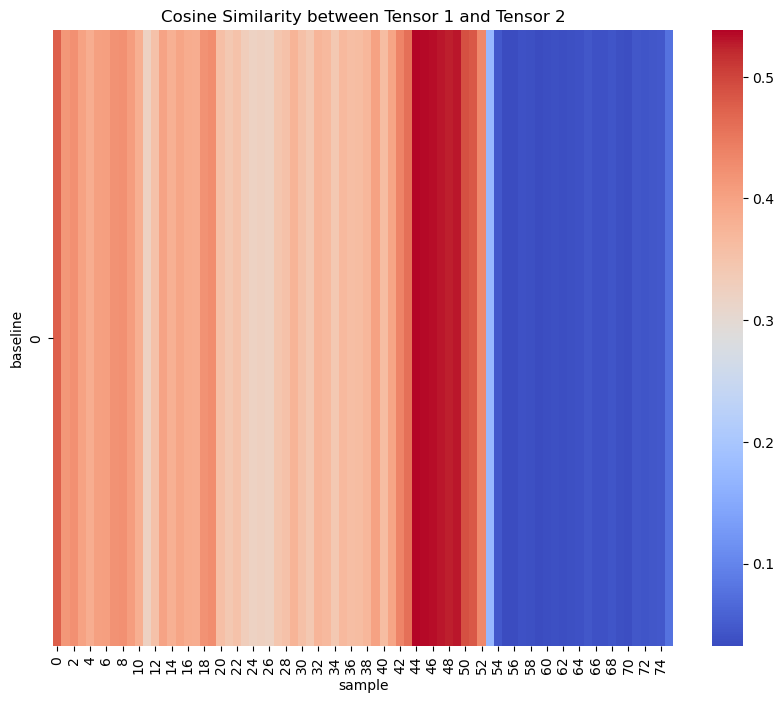

In [53]:
visualize_cosine_similarity(whole_sample,baseline )

In [39]:
class FaceEmbeddingEpisode():
    def __init__(self, path_to_response_dict,path_to_catalog,task,index):
        self.task=task
        self.index=index
        self.task_index=f"{task}_{index}"
        with open(path_to_response_dict,'rb') as file:
            self.response_dict =pickle.load(file)
        self.path_to_catalog=path_to_catalog
        self.error_type = None
        with open(self.path_to_catalog, mode='r') as file:
            csv_reader = csv.reader(file)
            
            # Iterate over each line in the CSV file
            for line in csv_reader:
                # Get the JSON string from the line
                json_string = line[0]
                
                # Load the JSON string into a dictionary
                data = json.loads(json_string)
                
                index=data.get('index')
                task_number=int(index.split('_')[1])
                episode_number=int(index.split('_')[2])
                if task_number==self.task and episode_number==self.index:
                    self.error_type= data.get('error_type')
        if self.error_type is None:
            raise ValueError("Error type not found in the catalog")
        self.list_of_frames=[]
        list_of_facial_embeddings=[]
        for key in self.response_dict.keys():
            self.list_of_frames.append(key)
            list_of_facial_embeddings.append(self.response_dict[key].cpu().numpy())
        
        self.facial_embedding_matrix = np.stack(list_of_facial_embeddings)


    def __str__(self):
        return f"Task: {self.task}, Index: {self.index},\nError Type: {self.error_type}, \nNumber of Frames: {len(self.list_of_frames)}, \nFacial Embedding Matrix Shape: {self.facial_embedding_matrix.shape}"





               
        

In [40]:
test_obj=FaceEmbeddingEpisode("/home/qihan/Playground/Data/User_3/face_data/0/3_8.pkl","/home/qihan/Playground/Data/User_3/catalog.csv",3,8)
print(test_obj)

Task: 3, Index: 8,
Error Type: No Error, 
Number of Frames: 76, 
Facial Embedding Matrix Shape: (76, 128)
